In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
import os
import json
import uuid

import rdkit
print(rdkit.__version__)
%load_ext sql
import lwreg
from lwreg import standardization_lib
from lwreg import utils
import psycopg2
import pandas as pd
import psycopg2
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'




2023.03.3


MD & MDFP experiment uuid: fc57851e-b654-4338-bcdd-faa28ec66253.

In [3]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = """
SELECT mdfp_experiment_data.confid, 
       mdfp_experiment_data.mdfp, 
       conformers.molregno, 
       experimental_data.*
FROM cs_mdfps_schema.mdfp_experiment_data
INNER JOIN public.conformers ON mdfp_experiment_data.confid = public.conformers.conf_id
INNER JOIN cs_mdfps_schema.experimental_data ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
"""

# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
mdfps = [json.loads(r[1]['mdfp']) for r in results]
vps = [r[6] for r in results]

In [15]:
#some checks: how many datapoints do we have? Are we missing any?
print(len(mdfps),' MDFPs')
print(len(vps),' VPs')
cur.execute("SELECT count(*) FROM cs_mdfps_schema.experimental_data")
print(cur.fetchall(), ' experimental data points')
molregnos_with_mdfp = [r[2] for r in results]
cur.execute("SELECT molregno FROM cs_mdfps_schema.experimental_data")
molregnos_with_vp = cur.fetchall()
molregnos_with_vp = [r[0] for r in molregnos_with_vp]
missing_molregnos = set(molregnos_with_vp) - set(molregnos_with_mdfp)
print(len(missing_molregnos), ' missing molregnos')
#we will have to fix this...
#THESE ARE ACTUAL ERRORS IN THE SIMULATIONS FOR DIFFERENT REASONS, #TODO: FIX THIS

3031  MDFPs
3031  VPs
[(3078,)]  experimental data points
55  missing molregnos


In [24]:
#But for now, lets move on to the ML part. Lets start with ShuZen's code, but attempting to get it a bit more clean
#Lets start with doing 5 fold cross validation, getting the plot and getting MAE, RMSE and R2
from sklearn.model_selection import KFold
import numpy as np
import tqdm
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from functools import reduce
from scipy.stats import linregress


def getStatValues(x,y):
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    this_rmse = mean_squared_error(np.array(x), np.array(y), squared=False)
    this_mue = mean_absolute_error(np.array(x), np.array(y))
    return slope, intercept, r_value**2, this_rmse, this_mue

kf = KFold(5)
X = mdfps
y = vps
num_boost_round = 999
params = {
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = ([],[])
rmse_arr , mae_arr = [] , []
for train, test in tqdm.tqdm(kf.split(X)):
    train_x = np.array(X)[train]
    train_y = np.array(y)[train]
    test_x = np.array(X)[test]
    test_y = np.array(y)[test]
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)

    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)


real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction, real)
print('RMSE: ', this_rmse)
print('MAE: ', this_mae)



5it [00:00, 12.41it/s]

RMSE:  1.3678203498273727
MAE:  0.8550810067931826


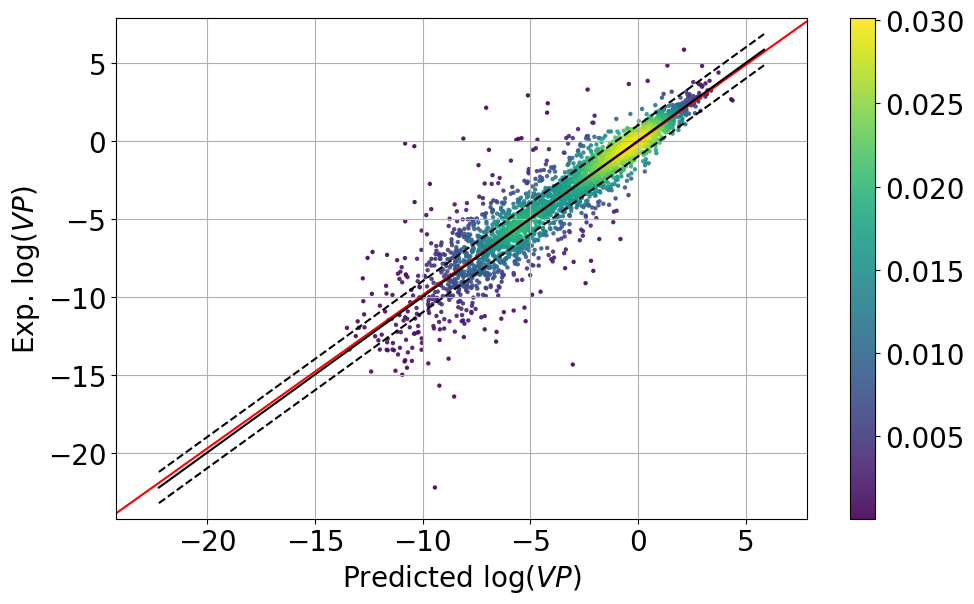

In [27]:
import matplotlib.pyplot as plt
fsize = 20
fig = plt.figure(1, figsize=(10, 6.15))
ax = plt.subplot(111)
lower = min(prediction + real) - 2
upper = max(prediction + real) + 2
x = np.linspace(lower, upper,100)
y = slope_mdfp_d*x+intercept_mdfp_d
plt.plot(x, y, '-r')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)-1, max(prediction + real) - 1], 'k--')
plt.plot([min(prediction + real), max(prediction + real)], [min(prediction + real)+1, max(prediction + real)+1], 'k--')

import statsmodels.api as sm
dens_u = sm.nonparametric.KDEMultivariate(data=[prediction, real],var_type='cc', bw='normal_reference')
z = dens_u.pdf([prediction, real])

sc = plt.scatter(prediction, real, lw=0, c=z, s=10, alpha = 0.9)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fsize)

plt.ylabel(r'Exp. $\log (VP)$', fontsize=fsize)
plt.xlabel(r'Predicted $\log (VP)$', fontsize=fsize)
plt.setp(ax.get_xticklabels(), fontsize=fsize)
plt.setp(ax.get_yticklabels(), fontsize=fsize)
plt.grid(1,"both")
plt.axis([lower, upper, lower, upper])
plt.tight_layout()
plt.show()

-13.507613 -22.22914798835785
None


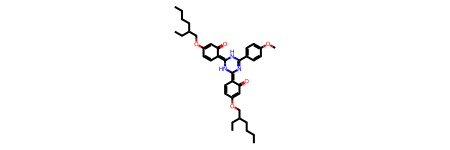

In [40]:
print(min(prediction),min(real))
#that one outlier seems strange, lets look at it
from rdkit import Chem
smiles = '[CH3]-[CH2]-[CH2]-[CH2]-[CH](-[CH2]-[CH3])-[CH2]-[O]-[C]1=[CH]-[C](=[O])/[C](=[C]2\[N]=[C](-[c]3:[cH]:[cH]:[c](-[O]-[CH3]):[cH]:[cH]:3)-[NH]/[C](=[C]3/[CH]=[CH]-[C](-[O]-[CH2]-[CH](-[CH2]-[CH3])-[CH2]-[CH2]-[CH2]-[CH3])=[CH]-[C]-3=[O])-[NH]-2)-[CH]=[CH]-1'
import cirpy
print(cirpy.resolve(smiles, 'cas'))
Chem.MolFromSmiles(smiles)

In [34]:
smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(smiles)))    

In [35]:
print(cirpy.resolve(smiles, 'cas'))

187393-00-6


In [42]:
#experiemtnal value is 5.9e-20 Pa, so log(kPa)=
reach_val = 5.9e-20/1000
#another source (echmi) says  1.37E-13mmHg, lets convert this to kPa
echmi_val = 1.37e-13 * 0.133322
#Chemspired says 0.0 +- 2.6 mmHg, lets convert this to kPa
chemspire_val_lower = -2.6* 0.133322
chemspire_val_upper = 2.6* 0.133322
print(reach_val, echmi_val, chemspire_val_lower, chemspire_val_upper)
#do we remove this point?
#get the index of the outlier
index = real.index(-22.22914798835785)
print(index)
#remove the outlier
real_no_outlier = real.copy()
real_no_outlier.pop(index)
prediction_no_outlier = prediction.copy()
prediction_no_outlier.pop(index)

slope_mdfp_d, intercept_mdfp_d, r2, this_rmse, this_mae = getStatValues(prediction_no_outlier, real_no_outlier)
print('RMSE: ', this_rmse)
print('MAE: ', this_mae)

5.9e-23 1.8265114e-14 -0.3466372 0.3466372
2895
RMSE:  1.3481441574847477
MAE:  0.8511393869140733


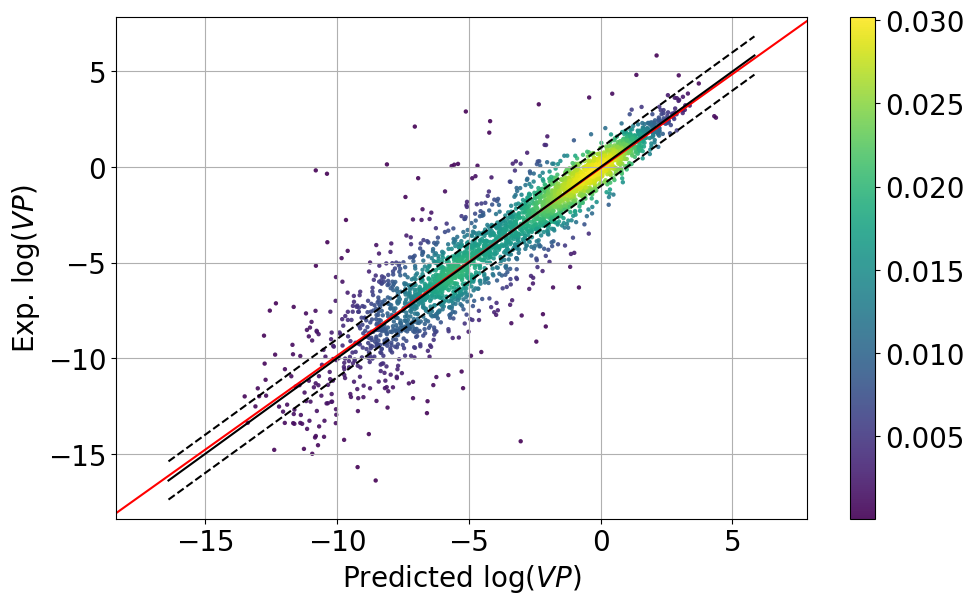

In [43]:
import matplotlib.pyplot as plt
fsize = 20
fig = plt.figure(1, figsize=(10, 6.15))
ax = plt.subplot(111)
lower = min(prediction_no_outlier + real_no_outlier) - 2
upper = max(prediction_no_outlier + real_no_outlier) + 2
x = np.linspace(lower, upper,100)
y = slope_mdfp_d*x+intercept_mdfp_d
plt.plot(x, y, '-r')
plt.plot([min(prediction_no_outlier + real_no_outlier), max(prediction_no_outlier + real_no_outlier)], [min(prediction_no_outlier + real_no_outlier), max(prediction_no_outlier + real_no_outlier)], 'k-')
plt.plot([min(prediction_no_outlier + real_no_outlier), max(prediction_no_outlier + real_no_outlier)], [min(prediction_no_outlier + real_no_outlier)-1, max(prediction_no_outlier + real_no_outlier) - 1], 'k--')
plt.plot([min(prediction_no_outlier + real_no_outlier), max(prediction_no_outlier + real_no_outlier)], [min(prediction_no_outlier + real_no_outlier)+1, max(prediction_no_outlier + real_no_outlier)+1], 'k--')

import statsmodels.api as sm
dens_u = sm.nonparametric.KDEMultivariate(data=[prediction_no_outlier, real_no_outlier],var_type='cc', bw='normal_reference')
z = dens_u.pdf([prediction_no_outlier, real_no_outlier])

sc = plt.scatter(prediction_no_outlier, real_no_outlier, lw=0, c=z, s=10, alpha = 0.9)

cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=fsize)

plt.ylabel(r'Exp. $\log (VP)$', fontsize=fsize)
plt.xlabel(r'Predicted $\log (VP)$', fontsize=fsize)
plt.setp(ax.get_xticklabels(), fontsize=fsize)
plt.setp(ax.get_yticklabels(), fontsize=fsize)
plt.grid(1,"both")
plt.axis([lower, upper, lower, upper])
plt.tight_layout()
plt.show()

In [51]:
print(min(real_no_outlier),min(prediction_no_outlier))
smiles = '[CH3]-[CH2]-[O]-[c]1:[n]:[c](-[F]):[cH]:[c]2:[n]:[c](-[S](=[O])(=[O])-[NH]-[c]3:[c](-[Cl]):[cH]:[cH]:[cH]:[c]:3-[C](=[O])-[O]-[CH3]):[n]:[n]:1:2'
smiles = Chem.MolToSmiles(Chem.RemoveHs(Chem.MolFromSmiles(smiles)))
print(cirpy.resolve(smiles, 'cas'))
Chem.MolFromSmiles(smiles)
#vap according to Unitated States Environmental Protection Agency
USEPA_val3 = 3e-16/7.5
print(USEPA_val3)

-16.397976925271976 -13.507613
147150-35-4
3.9999999999999997e-17


In [55]:
#lets also just get this out of the way: predicting the mean and look at values
mean = np.mean(vps)
mean_array = np.full(len(vps), mean)
#get r2, rmse and mae
mae = mean_absolute_error(np.array(vps), mean_array)
rmse = mean_squared_error(np.array(vps), mean_array, squared=False)
print('RMSE: ', rmse)
print('MAE: ', mae)
#good, we are not falling in that pitfall.



RMSE:  3.6097347005360234
MAE:  3.0108046071450234
